In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("paper", "whitegrid")
import pyBigWig
import pickle
from tqdm import tqdm
from scipy.signal import correlate

In [2]:
entropy = pyBigWig.open("../data/InformME/human colon normal METH NME ENTR MML VAR/ENTR-colon_normal-filled.bw")

file_with_tads = "../data/input/tad_boundaries_hESC_IMR90_hg19/h1.rep1.bed"
tad_boundaries = list(map(lambda x: x.split(), open(file_with_tads).readlines()))
tad_boundaries = np.array(tad_boundaries)
tad_boundaries = tad_boundaries[tad_boundaries[:, 0] != "chrX"]

In [3]:
tad_boundaries_per_chr = []
for chr in range(1, 23):
    tad_boundaries_per_chr.append(tad_boundaries[tad_boundaries[:, 0] == f"chr{chr}"][:, 1].astype(int))

In [4]:
tad_numbers = [A.shape[0] for A in tad_boundaries_per_chr]

# Make boundaries

In [20]:
WINDOW_RADIUS = 199950
SIZE = 150
IN_RADIUS = WINDOW_RADIUS // SIZE
windows_tads = []
windows_random = []

In [21]:
n_windows = len(tad_boundaries)

In [22]:
for i in range(1, 23):
    A = np.array(entropy.intervals(f"chr{i}"))
    for boundary in tqdm(tad_boundaries_per_chr[i - 1][1:-1]):
        boundary = boundary - WINDOW_RADIUS
        boundary = boundary // SIZE * SIZE
        windows_tads.append(A[(A[:, 0] >= boundary) & (A[:, 0] <= boundary + 2 * WINDOW_RADIUS), 2][:2 * IN_RADIUS])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 537.07it/s]


In [23]:
chroms = entropy.chroms()
for i, (chrom, size) in enumerate(chroms.items()):
    A = np.array(entropy.intervals(f"chr{i + 1}"))
    
    boundaries = np.random.randint(WINDOW_RADIUS, size - 2 * WINDOW_RADIUS, tad_numbers[i] * 10)
    for boundary in tqdm(boundaries):
        boundary = boundary // SIZE * SIZE
        windows_random.append(A[(A[:, 0] >= boundary) & (A[:, 0] <= boundary + 2 * WINDOW_RADIUS), 2][:2 * IN_RADIUS])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 933.32it/s]


## Save files

In [28]:
windows_tads = [A for A in windows_tads if A.size == 2 * IN_RADIUS]
pickle.dump(windows_tads, open("../data/output/windows_tads.pkl", "wb"))

In [29]:
windows_random = [A for A in windows_random if A.size == 2 * IN_RADIUS]
pickle.dump(windows_random, open("../data/output/windows_random.pkl", "wb"))

# Plotting

In [32]:
windows_tads = pickle.load(open("../data/output/windows_tads.pkl", "rb"))
windows_random = pickle.load(open("../data/output/windows_random.pkl", "rb"))

In [39]:
windows_tads = np.vstack(windows_tads)
windows_random = np.vstack(windows_random)

In [40]:
filter = np.ones(2 * IN_RADIUS).reshape(-1, 1)
filter[:IN_RADIUS] = -1
filter = filter.reshape(-1, 1)

responses_tads = windows_tads @ filter
responses_random = windows_random @ filter

In [41]:
responses_tads.shape

(209, 1)

In [42]:
responses_random.shape

(2151, 1)

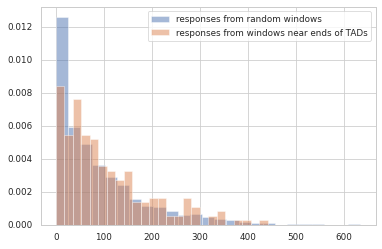

In [43]:
bins = 25
plt.hist(np.abs(responses_random), bins=bins, 
         label="responses from random windows", alpha=.5, density=True)
plt.hist(np.abs(responses_tads), bins=bins, 
         label="responses from windows near ends of TADs", alpha=.5, density=True)
plt.legend()
plt.show()

<AxesSubplot:ylabel='Density'>

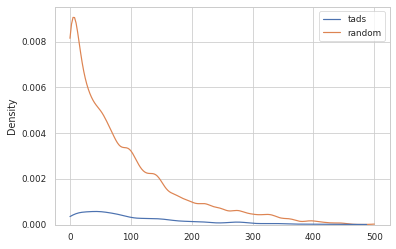

In [45]:
sns.kdeplot(data=
            pd.DataFrame([np.abs(responses_tads.ravel()), 
                          np.abs(responses_random.ravel())], index=["tads", "random"]).T,
           clip=(0, 500), bw_adjust=.5)

<AxesSubplot:ylabel='Density'>

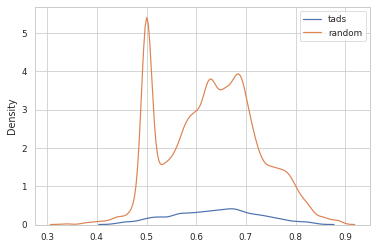

In [46]:
sns.kdeplot(data=
            pd.DataFrame([np.array(windows_tads).mean(axis=1), 
                          np.array(windows_random).mean(axis=1)], index=["tads", "random"]).T,
           bw_adjust=.5)

<AxesSubplot:ylabel='Density'>

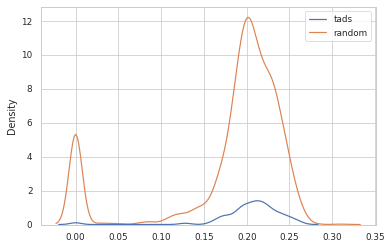

In [47]:
sns.kdeplot(data=
            pd.DataFrame([np.array(windows_tads).std(axis=1), 
                          np.array(windows_random).std(axis=1)], index=["tads", "random"]).T,
           bw_adjust=.5)

In [ ]:
X = np.concatenate([windows_random, windows_tads])

In [ ]:
y = np.ones(X.shape[0])
y[:len(windows_random)] = 0

In [ ]:
rng_state = np.random.get_state()
np.random.shuffle(X)
np.random.set_state(rng_state)
np.random.shuffle(y)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=243123)

In [ ]:
logreg = LogisticRegression(n_jobs=-1)

In [ ]:
logreg.fit(X_train, y_train)

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
for metrics in [accuracy_score, roc_auc_score, f1_score]:
    print(metrics(y_test, y_pred))

In [ ]:
plt.plot(logreg.coef_.ravel())